# KTR Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktr import KTRFull, KTRAggregated, KTRMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Pyro Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [13]:
ktr_pyro = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
    
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    level_knot_scale=10, 
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesn matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=200,
    estimator_type=PyroEstimatorVI,
)

In [14]:
%%time
ktr_pyro.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 7182.3, scale = 0.099752
step  100 loss = -213.89, scale = 0.55094
step  200 loss = -230.3, scale = 0.55079
step  300 loss = -230.26, scale = 0.56429
step  400 loss = -227.49, scale = 0.56138
step  500 loss = -229.13, scale = 0.55693
step  600 loss = -222.6, scale = 0.56518
step  700 loss = -226.96, scale = 0.56212
step  800 loss = -229.24, scale = 0.55339
step  900 loss = -229.47, scale = 0.55033
CPU times: user 3min 53s, sys: 8.56 s, total: 4min 2s
Wall time: 23.5 s


In [15]:
predicted_df = ktr_pyro.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.20484,12.34860,12.51402
1,2017-07-09,12.16718,12.34972,12.50713
2,2017-07-16,12.18591,12.32878,12.50137
3,2017-07-23,12.17592,12.31541,12.48313
4,2017-07-30,12.16445,12.30998,12.44767


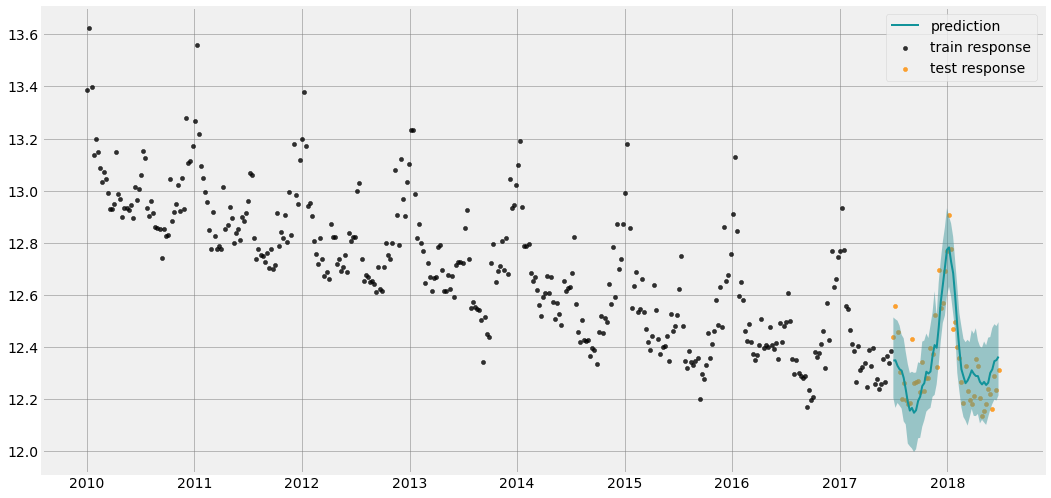

In [16]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [17]:
coef_df = ktr_pyro.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.13236,0.10570,0.19093
1,2010-01-10,0.13215,0.10593,0.19087
2,2010-01-17,0.13192,0.10616,0.19080
3,2010-01-24,0.13170,0.10640,0.19074
4,2010-01-31,0.13147,0.10664,0.19067


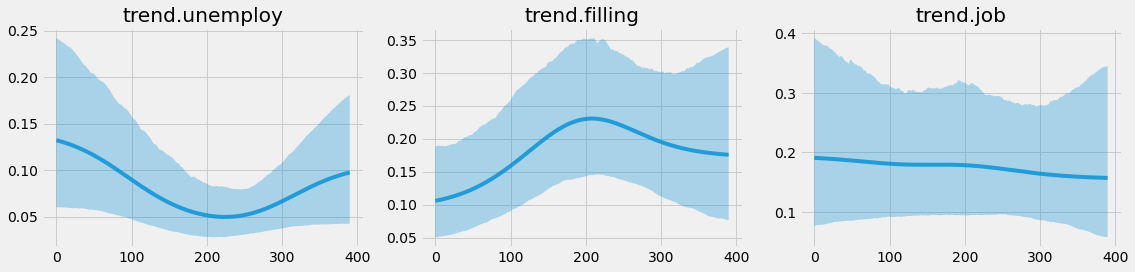

In [18]:
_ = ktr_pyro.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## Pyro Fit and Predict - Aggregated

In [19]:
ktr_pyro = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale=10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [20]:
%%time
ktr_pyro.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 3min 53s, sys: 8.96 s, total: 4min 2s
Wall time: 23 s


In [21]:
predicted_df = ktr_pyro.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.37533,12.36056,0.00714,0.00764
1,2017-07-09,12.38675,12.36056,0.00577,0.02042
2,2017-07-16,12.36909,12.36056,-0.00615,0.01469
3,2017-07-23,12.34623,12.36056,-0.02959,0.01526
4,2017-07-30,12.32016,12.36056,-0.06349,0.02309


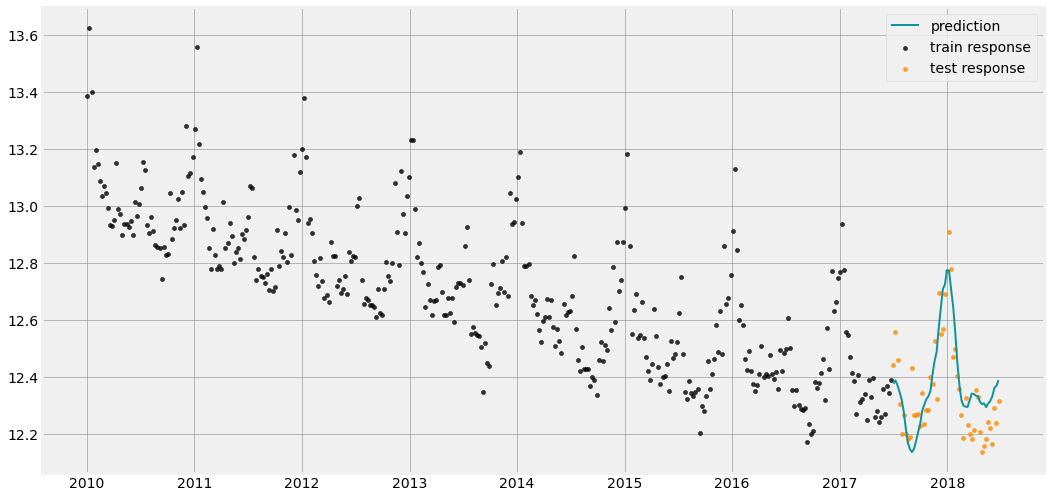

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [23]:
coef_df = ktr_pyro.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.06993,0.10628,0.19531
1,2010-01-10,0.06985,0.10639,0.19530
2,2010-01-17,0.06977,0.10650,0.19528
3,2010-01-24,0.06968,0.10662,0.19526
4,2010-01-31,0.06960,0.10674,0.19524


In [24]:
# extract future coefficients
coef_df2 = ktr_pyro.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,0.06245,0.13619,0.18765
1,2017-07-09,0.06253,0.13612,0.18761
2,2017-07-16,0.06260,0.13604,0.18757
3,2017-07-23,0.06267,0.13596,0.18753
4,2017-07-30,0.06274,0.13589,0.18749


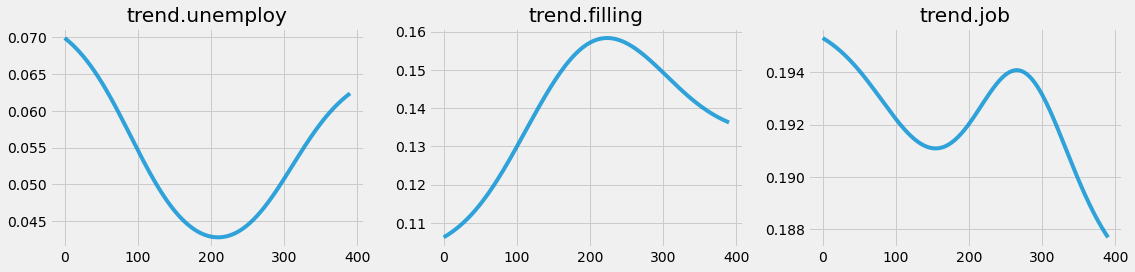

In [25]:
_ = ktr_pyro.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Pyro Fit and Predict - MAP

In [26]:
ktr_pyro = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,

    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    estimator_type=PyroEstimatorMAP,
)

In [27]:
%%time
ktr_pyro.fit(df=train_df)

CPU times: user 24.1 s, sys: 218 ms, total: 24.3 s
Wall time: 4.1 s


In [28]:
predicted_df = ktr_pyro.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.39853,12.38021,0.01633,0.00199
1,2017-07-09,12.39161,12.38021,0.00942,0.00199
2,2017-07-16,12.37466,12.38021,-0.00741,0.00186
3,2017-07-23,12.34891,12.38021,-0.03273,0.00143
4,2017-07-30,12.31790,12.38021,-0.06439,0.00209


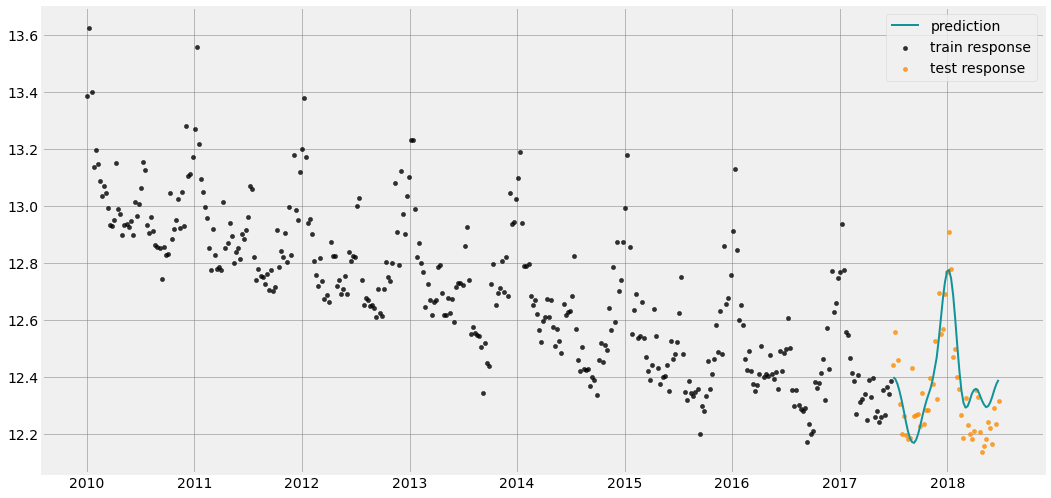

In [29]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [30]:
coef_df = ktr_pyro.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.08844,0.05793,0.09820
1,2010-01-10,0.08827,0.05794,0.09806
2,2010-01-17,0.08809,0.05796,0.09792
3,2010-01-24,0.08791,0.05797,0.09778
4,2010-01-31,0.08773,0.05799,0.09764


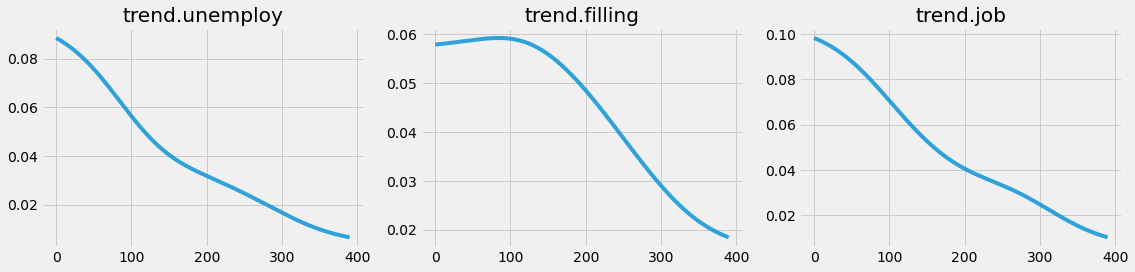

In [31]:
_ = ktr_pyro.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Stan Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [32]:
ktr_stan = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = .5, # smaller due to drift term; no big difference?
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
#     num_warmup = num_warmup,
#     num_sample = num_sample,
    n_bootstrap_draws=-1,
    estimator_type=StanEstimatorMCMC,
)

In [33]:
%%time
ktr_stan.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 203 ms, sys: 142 ms, total: 345 ms
Wall time: 35.3 s


In [34]:
predicted_df = ktr_stan.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.19533,12.35901,12.52806
1,2017-07-09,12.20491,12.37833,12.53496
2,2017-07-16,12.19407,12.34589,12.50875
3,2017-07-23,12.13277,12.34851,12.49823
4,2017-07-30,12.11828,12.30509,12.45339


In [35]:
predicted_df = ktr_stan.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.19533,12.35901,12.52806
1,2017-07-09,12.20491,12.37833,12.53496
2,2017-07-16,12.19407,12.34589,12.50875
3,2017-07-23,12.13277,12.34851,12.49823
4,2017-07-30,12.11828,12.30509,12.45339


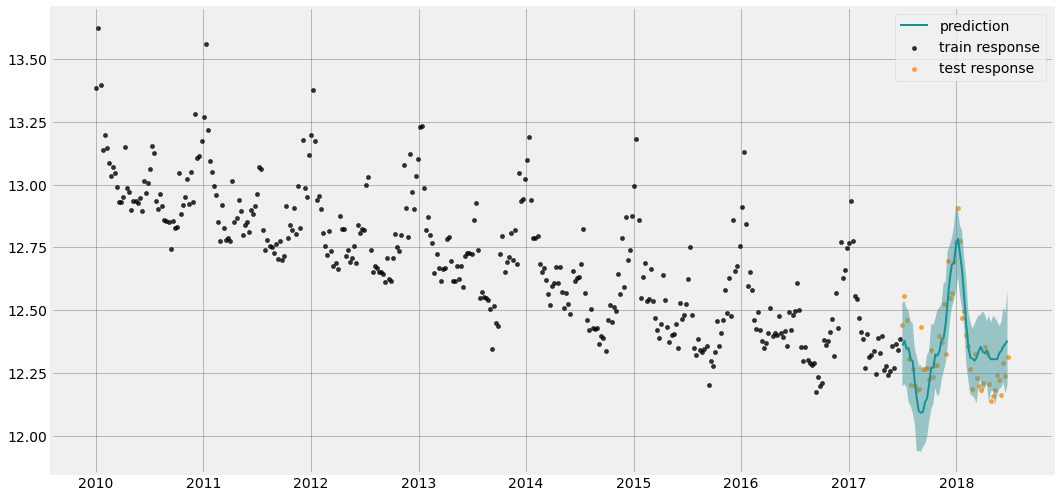

In [36]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [37]:
coef_df = ktr_stan.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.10463,0.12937,0.31189
1,2010-01-10,0.10459,0.12943,0.31184
2,2010-01-17,0.10455,0.12949,0.31179
3,2010-01-24,0.10452,0.12955,0.31174
4,2010-01-31,0.10448,0.12961,0.31169


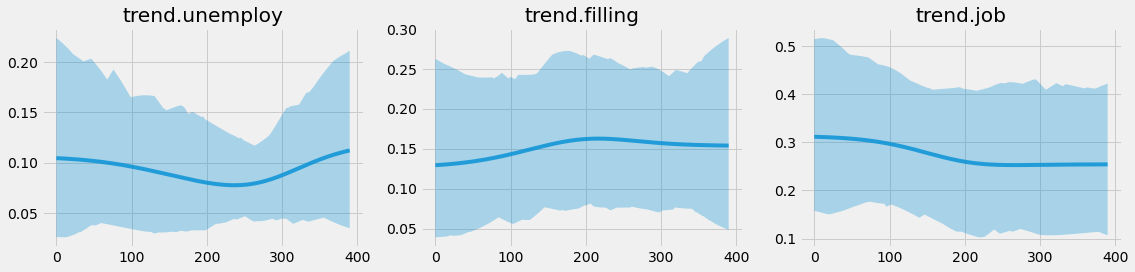

In [41]:
_ = ktr_stan.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## Stan Fit and Predict - Aggregated

In [42]:
ktr_stan = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = .5,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    aggregate_method='median',
    estimator_type=StanEstimatorMCMC,
)

In [43]:
%%time
ktr_stan.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 220 ms, sys: 154 ms, total: 374 ms
Wall time: 35 s


In [44]:
predicted_df = ktr_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.35539,12.33714,0.00745,0.01080
1,2017-07-09,12.37321,12.33714,0.00617,0.02990
2,2017-07-16,12.35329,12.33714,-0.00399,0.02015
3,2017-07-23,12.33371,12.33714,-0.02495,0.02153
4,2017-07-30,12.31136,12.33714,-0.05724,0.03147


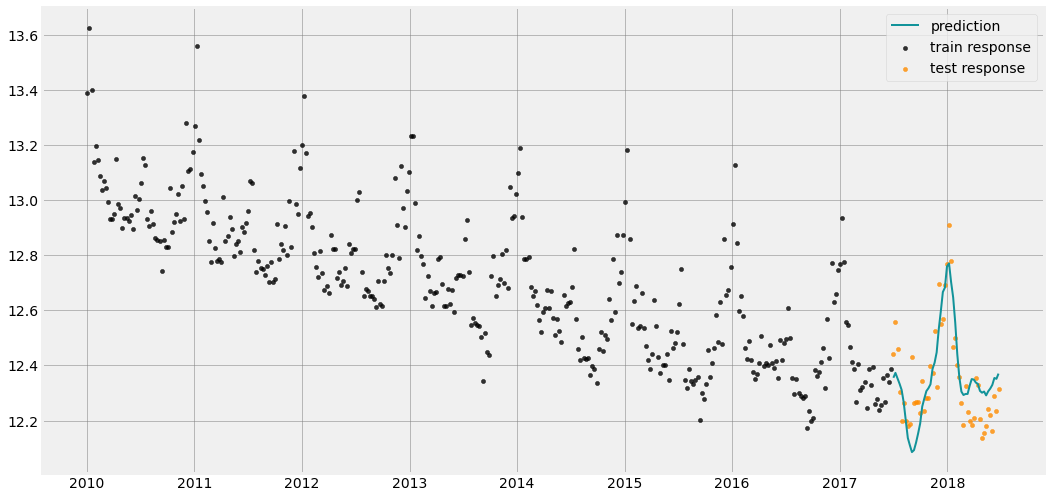

In [45]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [46]:
coef_df = ktr_stan.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.09344,0.11734,0.29462
1,2010-01-10,0.09344,0.11742,0.29464
2,2010-01-17,0.09343,0.11751,0.29466
3,2010-01-24,0.09342,0.11759,0.29468
4,2010-01-31,0.09341,0.11768,0.29471


In [47]:
# extract future coefficients
coef_df2 = ktr_stan.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,0.10161,0.14712,0.24091
1,2017-07-09,0.10176,0.14713,0.24091
2,2017-07-16,0.10192,0.14714,0.24092
3,2017-07-23,0.10207,0.14716,0.24092
4,2017-07-30,0.10221,0.14717,0.24093


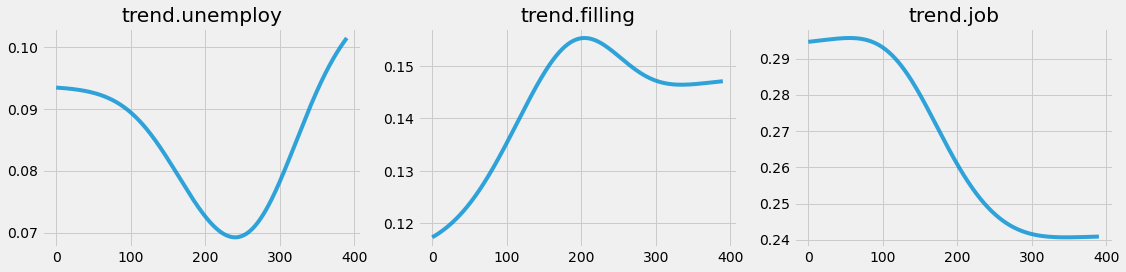

In [48]:
_ = ktr_stan.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Stan Fit and Predict - MAP

In [49]:
ktr_stan = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] *3,
    
    level_knot_scale = .5,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    estimator_type=StanEstimatorMAP,
)

In [50]:
%%time
ktr_stan.fit(df=train_df)

CPU times: user 397 ms, sys: 10.4 ms, total: 407 ms
Wall time: 407 ms


In [51]:
predicted_df = ktr_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.38508,12.36956,0.01552,0.00000
1,2017-07-09,12.38691,12.36956,0.01735,0.00000
2,2017-07-16,12.37846,12.36956,0.00890,0.00000
3,2017-07-23,12.35835,12.36956,-0.01121,0.00000
4,2017-07-30,12.32644,12.36956,-0.04312,0.00000


In [52]:
predicted_df = ktr_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.38508,12.36956,0.01552,0.00000
1,2017-07-09,12.38691,12.36956,0.01735,0.00000
2,2017-07-16,12.37846,12.36956,0.00890,0.00000
3,2017-07-23,12.35835,12.36956,-0.01121,0.00000
4,2017-07-30,12.32644,12.36956,-0.04312,0.00000


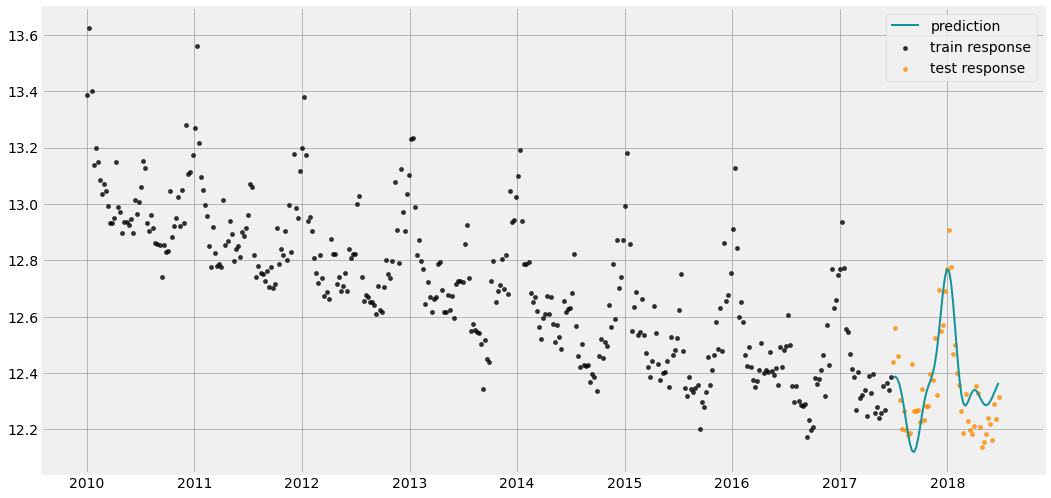

In [53]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [54]:
coef_df = ktr_stan.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.00000,0.00000,0.09361
1,2010-01-10,0.00000,0.00000,0.09330
2,2010-01-17,0.00000,0.00000,0.09297
3,2010-01-24,0.00000,0.00000,0.09265
4,2010-01-31,0.00000,0.00000,0.09232


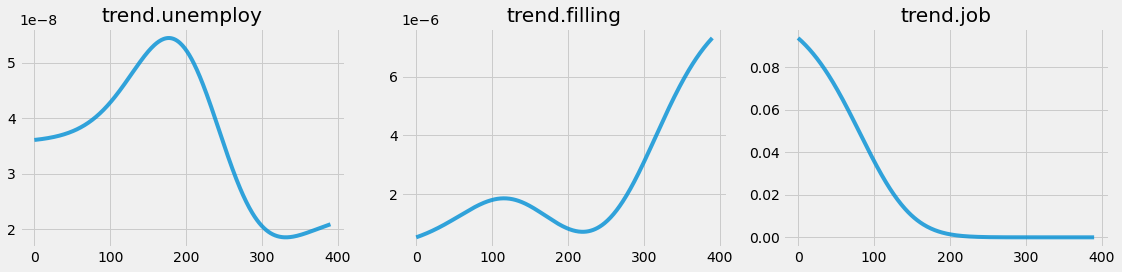

In [55]:
_ = ktr_stan.plot_regression_coefs(ncol=3, figsize=(16, 4))

## integrate stan outputs (level and seasonality) with pyro

In [158]:
# fit a stan model first
ktr_stan = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_sign=['+'] *3,
    
    level_knot_scale=.5,
#     regressor_knot_pooling_loc=[0] * 3,
#     regressor_knot_pooling_scale=[1] * 3,
#     regressor_knot_scale=[.1] * 3,
    
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    estimator_type=StanEstimatorMAP,
)

ktr_stan.fit(df=train_df)

In [159]:
level_knots_stan = ktr_stan._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_stan._level_knot_dates

seas_knots_input_dict = {
    '_seas_coef_knot_dates': ktr_stan._coef_knot_dates,
    '_sea_coef_knot': ktr_stan._aggregate_posteriors['map']['coef_knot'],
    '_sea_rho': ktr_stan._rho_coefficients,
    '_seasonality': ktr_stan._seasonality,
    '_seasonality_fs_order': ktr_stan._seasonality_fs_order,
}

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 474.69, scale = 0.099291
step  100 loss = -420.58, scale = 0.51146
step  200 loss = -411.32, scale = 0.51419
step  300 loss = -418.73, scale = 0.52949
step  400 loss = -421.33, scale = 0.51273
step  500 loss = -416.39, scale = 0.50748
step  600 loss = -409.27, scale = 0.51388
step  700 loss = -415.31, scale = 0.51977
step  800 loss = -418.99, scale = 0.5102
step  900 loss = -413.04, scale = 0.50943
0.006895317187708786


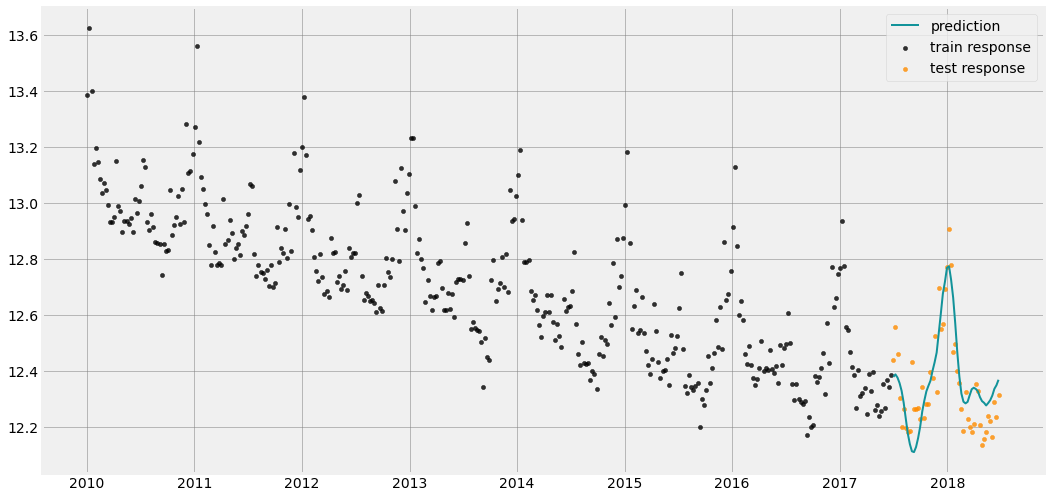

In [165]:
ktr_pyro = KTRAggregated(
    response_col='claims',
    date_col='week',
#     seasonality=52,
#     seasonality_fs_order=5,
    
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] *3,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    
    level_knot_scale=.01,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,
    seasonal_knots_input=seas_knots_input_dict,

    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    estimator_type=PyroEstimatorVI,
)

ktr_pyro.fit(df=train_df)

# meany - seas_term
# yhat
predicted_df = ktr_pyro.predict(df=test_df, decompose=True)
print(smape(test_df['claims'].values, predicted_df['prediction'].values))
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [171]:
ktr_pyro.get_regression_coefs()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.03906,0.03829,0.10191
1,2010-01-10,0.03902,0.03838,0.10188
2,2010-01-17,0.03898,0.03848,0.10184
3,2010-01-24,0.03893,0.03858,0.10181
4,2010-01-31,0.03889,0.03868,0.10178
...,...,...,...,...
386,2017-05-28,0.03231,0.06776,0.09731
387,2017-06-04,0.03234,0.06766,0.09738
388,2017-06-11,0.03237,0.06757,0.09744
389,2017-06-18,0.03240,0.06748,0.09751


In [172]:
ktr_pyro.get_regression_coefs(date_array=['2017-05-28', '2017-06-04', '2017-06-11'])

,week,trend.unemploy,trend.filling,trend.job
0,2017-05-28,0.03231,0.06776,0.09731
1,2017-06-04,0.03234,0.06766,0.09738
2,2017-06-11,0.03237,0.06757,0.09744


## hyper-parameter tuning

In [37]:
from orbit.diagnostics.backtest import grid_search_orbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [38]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


  6%|▋         | 1/16 [00:15<03:48, 15.21s/it]

tuning metric:0.065393
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 12%|█▎        | 2/16 [00:30<03:33, 15.26s/it]

tuning metric:0.012355
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 19%|█▉        | 3/16 [00:45<03:18, 15.30s/it]

tuning metric:0.090586
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 25%|██▌       | 4/16 [01:00<03:00, 15.05s/it]

tuning metric:0.081442
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 31%|███▏      | 5/16 [01:14<02:43, 14.89s/it]

tuning metric:0.068079
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 38%|███▊      | 6/16 [01:29<02:28, 14.84s/it]

tuning metric:0.15421
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 44%|████▍     | 7/16 [01:44<02:13, 14.85s/it]

tuning metric:0.012057
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


 50%|█████     | 8/16 [01:59<01:58, 14.75s/it]

tuning metric:0.16231
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


 56%|█████▋    | 9/16 [02:13<01:42, 14.70s/it]

tuning metric:0.068675
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 62%|██████▎   | 10/16 [02:28<01:28, 14.68s/it]

tuning metric:0.15767
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 69%|██████▉   | 11/16 [02:42<01:13, 14.62s/it]

tuning metric:0.072529
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 75%|███████▌  | 12/16 [02:57<00:58, 14.59s/it]

tuning metric:0.085704
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 81%|████████▏ | 13/16 [03:11<00:43, 14.56s/it]

tuning metric:0.086096
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 88%|████████▊ | 14/16 [03:26<00:29, 14.62s/it]

tuning metric:0.13729
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 94%|█████████▍| 15/16 [03:41<00:14, 14.62s/it]

tuning metric:0.08159
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


100%|██████████| 16/16 [03:55<00:00, 14.74s/it]

tuning metric:0.1716


In [43]:
tuned_df.head()

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.06539
1,0.15000,0.05000,0.20000,0.20000,0.01235
2,0.15000,0.05000,0.30000,0.10000,0.09059
3,0.15000,0.05000,0.30000,0.20000,0.08144
4,0.15000,0.10000,0.20000,0.10000,0.06808


In [42]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.1,
  'span_coefficients': 0.3,
  'span_level': 0.1}]

In [168]:
def reduce_by_max(x, n=2):
    out = x.copy()
    out[np.argsort(x)[:-n]] = 0
    return out

In [169]:
xx = np.array([1,2,3,4])

In [171]:
reduce_by_max(xx, n=1)

array([0, 0, 0, 4])

In [172]:
np.argsort(xx)[:-2]

array([0, 1])